# Visualization of training and results

In [59]:
############
# Packages #
############
import os
import sys
import numpy as np
import pickle
from pathlib import Path
import plotly.io as pio
import plotly.express as px
import plotly.graph_objects as go
import seaborn as sns
from prettytable import PrettyTable
import itertools

##################
#      Imports   #
##################
root_path = Path(os.getcwd())
# root_path should end by \nonlinear_ICA:
print(root_path)
sys.path.insert(0, str(root_path))
pio.renderers.default = "plotly_mimetype+notebook"

##############
#    Paths   #
##############
get_trainpath = lambda i: root_path.joinpath("models", "TCL", f"TCL_{i}")
get_respath = lambda i,j: root_path.joinpath("models", "classif", f"classif_{j}", "dataset_1", f"TCL_{i}", "NORM")

################
#   runs ids   #
################

TCL_ids = [1,2]
classif_ids = {
    1:[1], 
    2:[], 
    3:[]
}

#############
#    Load   #
#############
load_pkl = lambda path, name: pickle.load(open(str(path.joinpath(f"{name}.pkl")), 'rb'))

#############
#    Plot   #
#############

init_tab = lambda dct, lst: PrettyTable(list(dct.keys())+lst)
init_tab2 = lambda lst_dct: PrettyTable(  ["TCL","cl"]+list(itertools.chain.from_iterable([list(dct.keys()) for dct in lst_dct]))   )
list_val = lambda dct: list(dct.values())
list_valround = lambda dct: np.round(list(dct.values()),3).squeeze().tolist()
list_valround_k = lambda dct, k: np.round([ arr[k] for arr in dct.values()],3).squeeze().tolist()


C:\Users\samud\Bureau\Python code\MVA\Advanced ML\nonlinear_ICA


The following script gather results into tables. Please use an LLM to convert it into latex format.

## Training

In [2]:
start = True
for i in TCL_ids:
    params = load_pkl(get_trainpath(i),"params")
    train_loss =  load_pkl(get_trainpath(i),"model_loss")
    if start:
        tab = init_tab(params, ["accuracy", "f1"])
        start = False
    tab.add_row(list_val(params)+list(np.round(train_loss,3)))

print(tab)

+------------+---------------+------------+-----------+-----------+-------+----------+-------+
| num_layers | hidden_layers | activation | input_dim | pool_size | slope | accuracy |   f1  |
+------------+---------------+------------+-----------+-----------+-------+----------+-------+
|     1      |      [1]      | ['lrelu']  |     12    |     1     |  0.1  |  2.452   | 2.448 |
|     1      |      [3]      | ['lrelu']  |     12    |     1     |  0.1  |  2.359   | 2.357 |
|     1      |      [5]      | ['lrelu']  |     12    |     1     |  0.1  |  2.351   | 2.343 |
+------------+---------------+------------+-----------+-----------+-------+----------+-------+


## Results

In [45]:
start = True
for i in TCL_ids:
    for j in classif_ids[i]:
        best_params = load_pkl(get_respath(i,j),"best_params")
        res_best_model =  load_pkl(get_respath(i,j),"res_best_model")
                
        results_gs_SVM = load_pkl(get_respath(i,j),"results_gs_SVM")
        
        del results_gs_SVM["param_svm__C"]
        del results_gs_SVM["param_svm__gamma"]
        del results_gs_SVM["param_svm__kernel"]
        # del results_gs_SVM["std_fit_time"]
        params = results_gs_SVM["params"]
        del results_gs_SVM["params"] #doublons
        
        if start:
            tab_train = init_tab2([best_params, res_best_model["train"]])
            tab_test = init_tab2([best_params, res_best_model["test"]])
            tab_svm = init_tab2([{"params":[]}, results_gs_SVM])
            strat = False
        tab_train.add_row([i,j] + list_val(best_params)+ list_valround(res_best_model["train"]))
        tab_test.add_row([i,j] + list_val(best_params)+ list_valround(res_best_model["test"]))
        for k in range(results_gs_SVM["mean_fit_time"].shape[0]):
            params_k = list(params[k].values()) 
            params_k = list(map(str, params_k))
            tab_svm.add_row([i,j] + [":".join(params_k)] +list_valround_k(results_gs_SVM, k))

print("\nTRAIN BEST \n",tab_train)
print("\nTEST BEST \n",tab_test)
print("\nGRID \n",tab_svm)


TRAIN BEST 
 +-----+----+--------+------------+-------------+----------+----------+--------+-----------+---------+
| TCL | cl | svm__C | svm__gamma | svm__kernel | accuracy | f1_score | recall | precision | roc_auc |
+-----+----+--------+------------+-------------+----------+----------+--------+-----------+---------+
|  1  | 1  |  0.1   |   scale    |    linear   |  0.628   |  0.604   | 0.651  |   0.564   |  0.676  |
+-----+----+--------+------------+-------------+----------+----------+--------+-----------+---------+

TEST BEST 
 +-----+----+--------+------------+-------------+----------+----------+--------+-----------+---------+
| TCL | cl | svm__C | svm__gamma | svm__kernel | accuracy | f1_score | recall | precision | roc_auc |
+-----+----+--------+------------+-------------+----------+----------+--------+-----------+---------+
|  1  | 1  |  0.1   |   scale    |    linear   |  0.597   |  0.567   | 0.604  |   0.535   |  0.643  |
+-----+----+--------+------------+-------------+-------

### Transformed signals

In [97]:
def my_pal(n):
    return sns.color_palette("Spectral", n).as_hex()

#Simple
def plot_signal(vec, title = "signal"):
    fig = px.line(vec, template = "plotly_dark", title = title)
    fig.show()

def plot_all_st(X, clustering=None, title="<b>Signals</b>"):
    """
    Plot multiple signals in a single interactive Plotly figure.

    Args:
        X (list of arrays): A list of signal arrays to be plotted.
        clustering (list or None, optional): A list of cluster assignments for each signal. 
            If provided, signals will be color-coded by cluster. Default is None.
        title (str, optional): The title of the plot. Default is "<b>Signals</b>".

    Returns:
        None: Displays an interactive Plotly figure with the plotted signals.
    """
    
    fig = go.Figure(
        layout=go.Layout(
            height=600, 
            width=800, 
            template = "plotly_dark", 
            title = title
    ))
        
    if clustering:
        pal = ["palegreen", "darkred"]
    else:
        pal = sns.color_palette("Spectral", len(X)).as_hex()

    for i in range(len(X)):
        if clustering:
            color = pal[clustering[i]]
        else:
            color = pal[i]
            
        fig.add_trace(go.Scatter(y=X[i], 
                                 mode="lines", 
                                 line=dict(
                                     width=2,
                                     color=color,
                                 ),
                                 opacity = 0.6
                                ))
    fig.show()

In [70]:
path_train_info1 = get_respath(1,1).joinpath("train_info.pkl")
path_train_info2 = get_respath(2,1).joinpath("train_info.pkl")
with open(path_train_info1, 'rb') as f:
    train_info1 = pickle.load(f)
    
with open(path_train_info2, 'rb') as f:
    train_info2 = pickle.load(f)

In [71]:
print(list(train_info1))
print(train_info1["features_all"].numpy().squeeze().shape)

['id_patient', 'features_avg', 'features_all']
(17441, 1000)


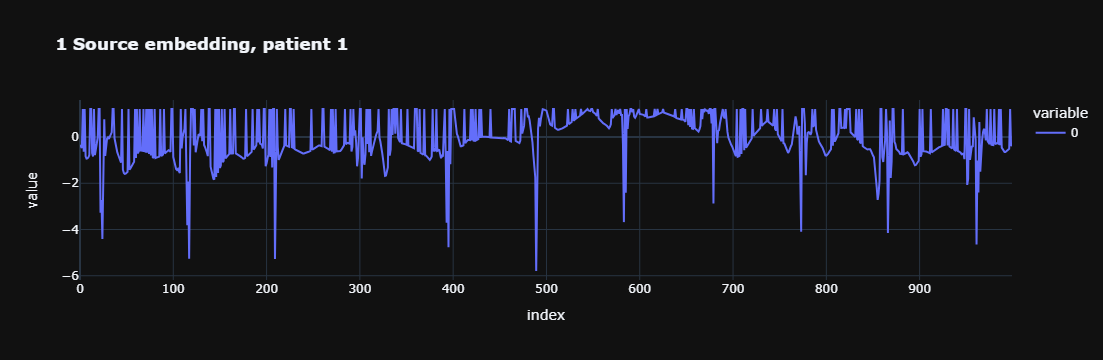

In [98]:
plot_signal(train_info1["features_all"].numpy().squeeze()[0,:], title="<b><b>1 Source embedding, patient 1</b></b>")

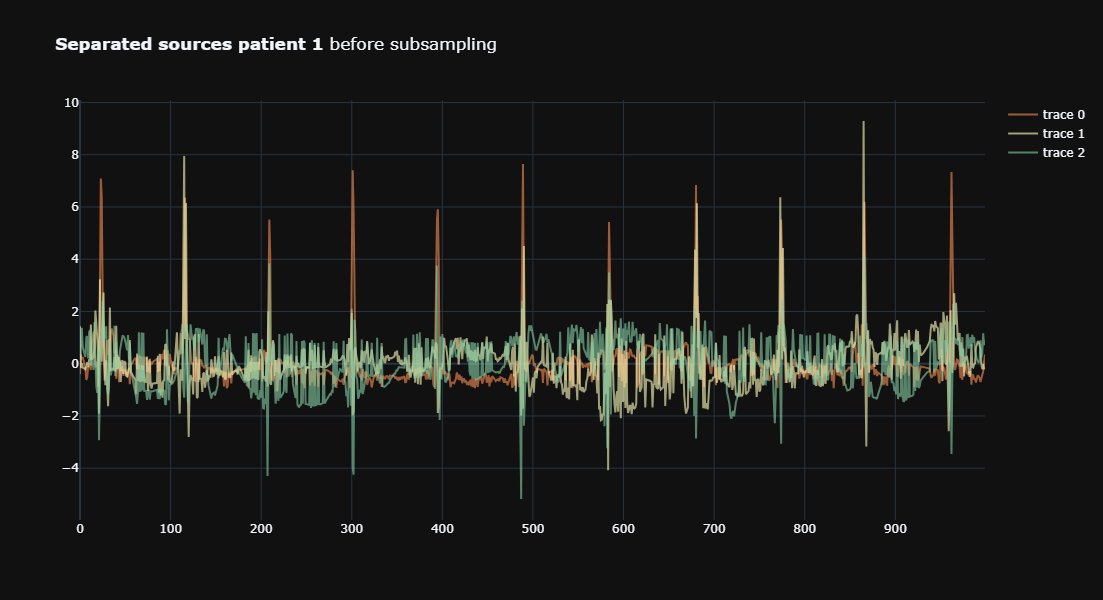

In [95]:
plot_all_st(train_info2["features_all"].numpy().squeeze()[0,:,:], clustering=None, title="<b>Separated sources patient 1</b> before subsampling")

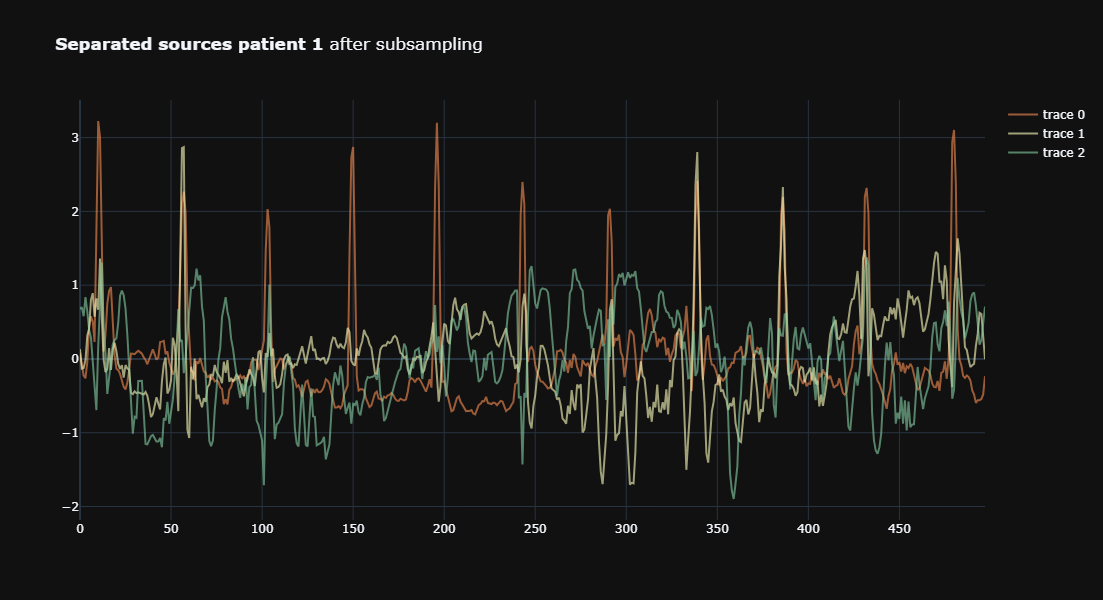

In [94]:
plot_all_st(train_info2["features_avg"].numpy().squeeze()[0,:,:], clustering=None, title="<b>Separated sources patient 1</b> after subsampling")

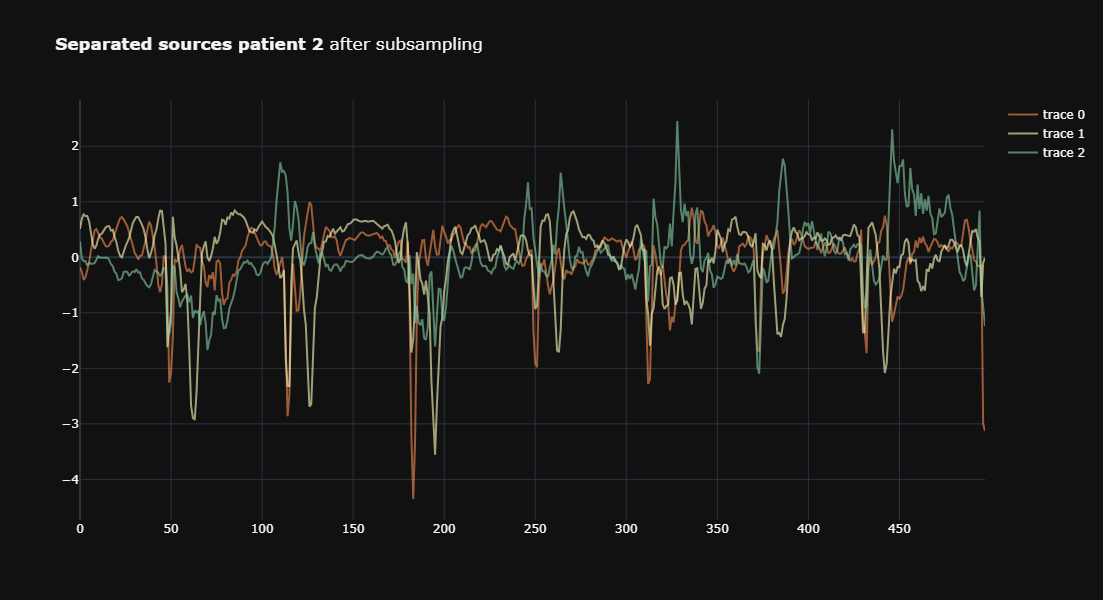

In [93]:
plot_all_st(train_info2["features_avg"].numpy().squeeze()[1,:,:], clustering=None, title="<b>Separated sources patient 2</b> after subsampling")